## Simulated Annealing: Finding the shortest tour around Nigerian airports

**Introduction.** The traveling salesperson problem, which is among a class of problems called NP-complete, asks for the shortest path or tour between each pair of `N` cities, where the path visits each city once and then returns to the origin city. Though there is no known way to calculate an exact solution in a time that is less than exponential in the size of the input, we can use a heuristic solution method called simulated annealing.

Simulated annealing uses a probabilistic technique to find a solution to TSP by exploring potential solutions by occasionally taking one even if it increases the cost function. It does so more frequently at the beginning, but gradually accepts less and less higher cost solution as the computation progresses. In the end, this approximates a global optimum to the cost function. In exploring potential solutions, we use the neighbours of a state to probabilistically decide between moving the system to the new state or staying in the current state.

**Problem.** In this problem, we use simulated annealing to find the shortest tour around airports in Nigeria. We consider that a person intends to take a tour around the country starting from one airport and flying to a new airport every time until all the airports in the country are visited. We consider the fastest way to achieve this and the shortest tour possible across all airports.

We define the SA procedure using the algorithmic idea:

1. Start with any random path through the airports
2. For some number of iteration, do the following:
    - Randomly swap two airports in the defined random path
    - If this new path is shorter, accept it. Otherwise, accept it with probability $p$.
    - Repeat procedure

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [3]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap

**Solution.** First, we define a `RANDOM_PATH` which is a random sequence of travel from one airport to another across the country. We do not expect this random path to be optimal. However, using simulated annealing, we will be moving from the random path to a optimum solution while temporarily accepting even worse solutions.

We use a `csv` file which has details of the airports in Nigeria. These details include the longitude and latitude of each airport. We will be defining the distance between any two aiports in terms of their longitudes and latitudes.

In [5]:
airports = pd.read_csv('./data/ng-airports.csv')
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,country_name,iso_country,...,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords,score,last_updated
0,#meta +id,#meta +code,#loc +airport +type,#loc +airport +name,#geo +lat,#geo +lon,#geo +elevation +ft,#region +continent +code,#country +name,#country +code +iso2,...,#loc +municipality +name,#status +scheduled,#loc +airport +code +gps,#loc +airport +code +iata,#loc +airport +code +local,#meta +url +airport,#meta +url +wikipedia,#meta +keywords,#meta +score,#date +updated
1,2118,DNMM,large_airport,Murtala Muhammed International Airport,6.5773701667785645,3.321160078048706,135,AF,Nigeria,NG,...,Lagos,1,DNMM,LOS,NaN,http://www.faannigeria.org/nigeria-airport.php...,https://en.wikipedia.org/wiki/Murtala_Mohammed...,NaN,1275,2009-03-02T11:53:36+00:00
2,2104,DNAA,large_airport,Nnamdi Azikiwe International Airport,9.006790161132812,7.263169765472412,1123,AF,Nigeria,NG,...,Abuja,1,DNAA,ABV,NaN,http://www.faannigeria.org/nigeria-airport.php...,https://en.wikipedia.org/wiki/Nnamdi_Azikiwe_I...,NaN,1275,2009-03-02T11:54:21+00:00
3,2120,DNPO,medium_airport,Port Harcourt International Airport,5.0154900550842285,6.94959020614624,87,AF,Nigeria,NG,...,Port Harcourt,1,DNPO,PHC,NaN,http://www.faannigeria.org/nigeria-airport.php...,https://en.wikipedia.org/wiki/Port_Harcourt_In...,NaN,1050,2009-03-02T11:56:34+00:00
4,2115,DNKN,large_airport,Mallam Aminu International Airport,12.0476,8.52462,1562,AF,Nigeria,NG,...,Kano,1,DNKN,KAN,NaN,http://www.faannigeria.org/nigeria-airport.php...,https://en.wikipedia.org/wiki/Mallam_Aminu_Kan...,NaN,1475,2018-03-18T09:54:27+00:00


Some of the attributes, such as `country_name`, `iso_country`, etc., are not relevant to our task, so we will be selecting only the useful ones.

In [7]:
airports = airports.iloc[1:][['id', 'ident', 'type', 'name', 'latitude_deg', 'longitude_deg',
                  'region_name', 'municipality']]
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,region_name,municipality
1,2118,DNMM,large_airport,Murtala Muhammed International Airport,6.5773701667785645,3.321160078048706,Lagos,Lagos
2,2104,DNAA,large_airport,Nnamdi Azikiwe International Airport,9.006790161132812,7.263169765472412,Abuja Capital Territory,Abuja
3,2120,DNPO,medium_airport,Port Harcourt International Airport,5.0154900550842285,6.94959020614624,Rivers,Port Harcourt
4,2115,DNKN,large_airport,Mallam Aminu International Airport,12.0476,8.52462,Kano,Kano
5,2114,DNKA,medium_airport,Kaduna Airport,10.696000099182129,7.320109844207764,Kaduna,Kaduna


In [8]:
airports.isnull().sum()

id               0
ident            0
type             0
name             0
latitude_deg     0
longitude_deg    0
region_name      0
municipality     7
dtype: int64

Some of the airports are missing entries under `municipality`. These are `Eket Airport`, `Escravos Airport`, `Kaduna Old Airport`, `Ajaokuta Airport`, `Shiroro Airport`, `Kainji` and `Agbara-Otor`. We observe that if we remove the "Airport" description in front of `name`, we are left with a string which describes the observation and is suitable enough for use as entries under `municipality`.

In [9]:
airports[airports.municipality.isnull()]

,id,ident,type,name,latitude_deg,longitude_deg,region_name,municipality
25,4969,DN55,small_airport,Eket Airport,4.642182,7.94904,Akwa Ibom,NaN
26,4970,DN56,small_airport,Escravos Airport,5.61673,5.188485,Delta,NaN
27,4967,DN53,small_airport,Kaduna Old Airport,10.598899841308594,7.448709964752197,Kaduna,NaN
28,4966,DN51,small_airport,Ajaokuta Airport,7.457240104675293,6.461130142211914,Kogi,NaN
29,4965,DN50,small_airport,Shiroro Airport,9.884650230407715,6.818630218505859,Niger,NaN
30,42464,NG-0002,small_airport,Kainji,9.892666816711426,4.485443592071533,Niger,NaN
36,42463,NG-0001,closed,Agbara-Otor,5.529193878173828,6.058831214904785,Delta,NaN


In [10]:
missingna = airports[airports.municipality.isnull()].name.str.replace('Airport' ,'')
missingna

25          Eket 
26      Escravos 
27    Kaduna Old 
28      Ajaokuta 
29       Shiroro 
30         Kainji
36    Agbara-Otor
Name: name, dtype: object

In [11]:
airports.loc[airports.municipality.isnull(), 'municipality'] = missingna
airports.iloc[random.sample(list(airports.index), 5)] #Display a random sample of five airports

,id,ident,type,name,latitude_deg,longitude_deg,region_name,municipality
24,2123,DNZA,medium_airport,Zaria Airport,11.1302,7.68581,Kaduna,Zaria
8,2117,DNMK,medium_airport,Makurdi Airport,7.70388,8.61394,Benue,Makurdi
28,4966,DN51,small_airport,Ajaokuta Airport,7.457240104675293,6.461130142211914,Kogi,Ajaokuta
36,42463,NG-0001,closed,Agbara-Otor,5.529193878173828,6.058831214904785,Delta,Agbara-Otor
45,300565,NG-0004,small_airport,Port Harcourt City Airport,4.846111111110001,7.021388888890001,Rivers,Port Harcourt


The types of attributes `latitude_deg` and `longitude_deg` are `object` and should be changed to `float` types.

In [12]:
airports.dtypes

id               object
ident            object
type             object
name             object
latitude_deg     object
longitude_deg    object
region_name      object
municipality     object
dtype: object

In [13]:
airports.latitude_deg = airports.latitude_deg.astype(float)
airports.longitude_deg = airports.longitude_deg.astype(float)
airports.name = airports.name.astype(str)

We define the variable `AIRPORTS` which hold the longitude and latitude for each airport. We also define a random path, `RANDOM_PATH`, through all airports in the country. This `RANDOM_PATH` is the initial path randomly determined.

In [14]:
AIRPORTS = [tuple(i) for i in airports[['latitude_deg', 'longitude_deg']].values.tolist()]
RANDOM_PATH = list(range(len(AIRPORTS)))
random.shuffle(RANDOM_PATH)

`plot_path` plots the path from one airport to the other defined according to the parameters, `path` and `points`. `path` describes the path followed, while `points` define the longitude and latitude for each airport station.

In [15]:
def plotPath(path, points):
    fig = plt.figure(figsize=(8, 8))
    m = Basemap(projection='lcc', 
                lat_0=8, lon_0=8,
                width=1.5E6, height=1.5E6)
    m.drawcoastlines(color='black')
    m.drawcountries(color='black')
    m.drawstates(color='black')
    lat, lon = list(zip(*points))
    lat = np.array(lat)
    lon = np.array(lon)
    m.plot(lon[path], lat[path],
             latlon=True,
             marker='o',
             markersize=4,
             linewidth=0.5)

The initial random path `RANDOM_PATH` through all airports is visualized below.

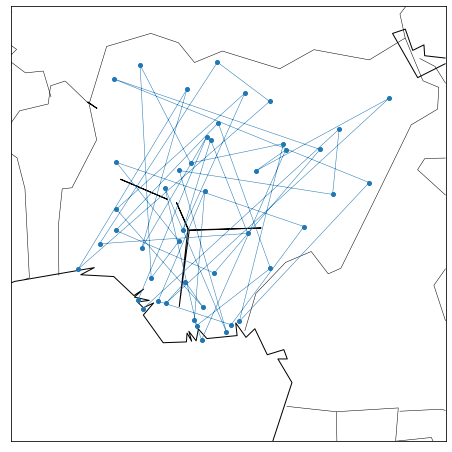

In [16]:
plotPath(RANDOM_PATH, AIRPORTS)

We use the helper function `calcDistance` to determine the distance between any two airports using their respective longitude and latitude in degrees. This will help in calculating the cumulative distance of the tour through the airports as we walk through whatever path. Any tour starts at airport `A`, walks through all airports in the country, and ends again at airport `A`. `calcDistance` obtains the distance between any airport `A` and `B`.

`calcPathDistance` calculates the total tour distance starting from airport `A`. This is defined as:

$$(\sum_{i}^{n-1}{dist(X_i, X_{i+1})}) + dist(X_n, X_0)$$

The extra addition term closes the loop in the tour so that the traveler ends at airport `A`.

In [17]:
def calcDistance(airport_a, airport_b):
    '''
    Calculates the distance between airport A and airport B
    '''
    import math
    
    lat1, lon1 = airport_a
    lat2, lon2 = airport_b

    R = 6371e3
    phi_1 = lat1 * math.pi/180
    phi_2 = lat2 * math.pi/180

    delta_phi = (lat2-lat1) * math.pi/180
    delta_lambda = (lon2-lon1) * math.pi/180

    a = math.sin(delta_phi/2) * math.sin(delta_phi/2) + \
    math.cos(phi_1) * math.cos(phi_2) * \
    math.sin(delta_lambda/2) * math.sin(delta_lambda/2)

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = R * c
    return d

def calcPathDistance(path, airports):
    '''
    Determine distance of tour through airports
    Any tour starts at path[0] and ends at path[0]
    after going through all airports in the country.
    Returns total distance.
    '''
    sum_ = 0
    i=0
    while i < len(path)-1:
        sum_ += calcDistance(airports[path[i]], airports[path[i+1]])
        i+=1
    sum_ += calcDistance(airports[path[i]], airports[path[0]])
    return sum_

In [18]:
print (f" Total distance covered following initial random tour is {calcPathDistance(RANDOM_PATH, AIRPORTS) / 1e3} km \
and starts/ends at {airports.iloc[RANDOM_PATH[0]]['name']}")

 Total distance covered following initial random tour is 22406.13366515736 km and starts/ends at Escravos Airport


As expected, the path followed by `RANDOM_PATH` is not optimal and lasts about 21577km. This tour starts and ends at Escravos Airport.

We now use simulated annealing to obtain a optimal path through all the airports. We expect that this will produce a significantly shorter tour than that afforded by `RANDOM_PATH`.

We implement another helper function, `swapAirports`, which swaps two airports present in a path. This function takes as input a `path` and two additional integers, `i` and `j`, which represent the indices of the two airports to be swapped. The function returns a new path variable which has the swapped airports present. Swapping changes the state of the path and allows us to obtain a new distance value which we can check if is any better than the older one.

In [19]:
def swapAirports(path, i, j):
    path_copy = path.copy()
    path_copy[i], path_copy[j] = path_copy[j], path_copy[i]
    return path_copy

The next function, `acceptanceProbability`, computes the value of $p$ in the SA algorithm. This is the probability of accepting a solution. If the new solution is strictly better than the old one, i.e. if $new\_distance < old\_distance$, we accept the new distance value. Here $p$ evaluates to 1. If the new solution is equal to or worse than the old distance, i.e. $new\_distance \le old\_distance$, then the probability that we will accept it is less than or equal to 1. The expression for determining this probability value is given as:

$$p = exp^{\frac{old\_distance-new\_distance}{k}}$$

$old\_distance$ is the distance derived using the original path, while $new\_distance$ is obtained from the new path. $k$ is the temperature of the system.

While $k$ is high, $p = exp^{\frac{old\_distance-new\_distance}{k}}$ evaluates more often to higher values of $p$, so that we are more likely to accept even worse solutions and therefore adequately explore the solution space. As the temperature cools, or $k$ reduces in value, the algorithm becomes less likely to accept worse solutions. This is because if $(old\_distance-new\_distance)$ evaluates to higher negative values and $k$ is low, we obtain values of $p$ much closer to zero and as a result a distance update will not occur. $new\_distance$ values which however produce smaller deviations from $old\_distance$ are likely to be accepted.

In [20]:
def acceptanceProbability(old_distance, new_distance, k):
    '''
    Determine probability associated with new distance value obtained
    Returns probability (0<=p<=1)
    '''
    if new_distance < old_distance:
        p = 1
    else:
        p = np.exp((old_distance - new_distance) / k )
    return p

We will now implement the SA algorithm using all the functions defined. We start with a random path of the airports, `RANDOM_PATH`. Next, we iterate over a sequence of temperature which starts at 100,000 and decreases logarithmically to 1.

At each temperature iteration, we
- Randomly swap two airports in a path
- If the newly created path is strictly shorter, we accept it. Else, we accept it only with probability $p$.
- In accepting a new distance if it is greater than the older value, we threshold the acceptance probability, $p$, by emulating the flipping a biased coin.

We start out with `RANDOM_PATH`, which is a tour around all airports with each stop randomly determined.

Final path: [41, 25, 5, 27, 43, 28, 22, 10, 38, 29, 9, 34, 15, 0, 20, 32, 16, 36, 30, 18, 31, 19, 7, 37, 14, 1, 26, 4, 23, 33, 3, 39, 12, 13, 42, 45, 11, 8, 24, 40, 44, 2, 21, 17, 35, 6]
The length of this path: 6734780.8694959525


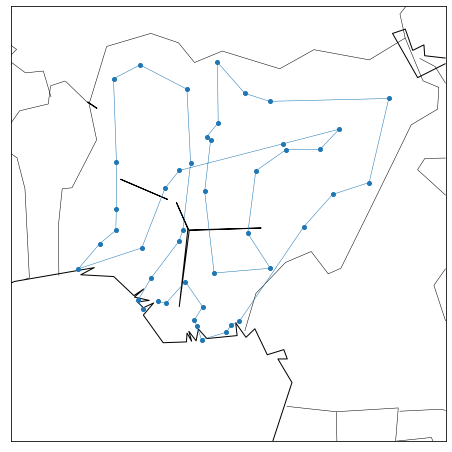

In [21]:
path = RANDOM_PATH
for k in np.logspace(0, 5, num=100000)[::-1]:
    dist = calcPathDistance(path, AIRPORTS)
    i = np.random.choice(path)
    j = np.random.choice(list(set(path)-{i}))
    i, j = int(i), int(j)
    new_path = swapAirports(path, i, j)
    new_dist = calcPathDistance(new_path, AIRPORTS)
    proba = acceptanceProbability(dist, new_dist, k)
    if proba > (sum([np.random.random() >= 0.3 for _ in range(20)]) / 20):
        path = new_path
    else:
        path = path


print("Final path: {}".format(path))
print("The length of this path: {}".format(calcPathDistance(path, AIRPORTS)))
plotPath(path, AIRPORTS)

We manage to find a shorter tour through the airports which lasts 6734km, significantly less than the tour obtained from `RANDOM_PATH`. We have achieved this using the simulated annealing optimization routine. As `k` reduces in value, we accept poorer solutions less and are more likely to keep the solution good.

We can see this using the routine below which assembles the different paths and distances as we go through the optimization routine. This routine obtains decreasing indices of the `path` and `distance` values in order to see how they change over time as the optimization attempt converges to our value of the shortest tour. We use several images to create a gif file.

It is immediately noticeable that the algorithm converges to an answer very fast in the first few iterations. Subsequently, there is not a lot of change in the answer obtained over the next iterations. By this time, only little changes are made to the answer, with the algorithm less likely to accept a worse solution as the "temperature" cools.

  <p align="center">
    <img src="./data/4sthfk.gif" width="800">
    <br>
  </p> 

The code below produces the sequence of images

In [25]:
path = RANDOM_PATH
all_paths = []
distt = []
for k in np.logspace(0, 5, num=100000)[::-1]:
    dist = calcPathDistance(path, AIRPORTS)
    all_paths.append(path)
    temps.append(k)
    distt.append(dist)
    i = np.random.choice(path)
    j = np.random.choice(list(set(path)-{i}))
    i, j = int(i), int(j)
    new_path = swapAirports(path, i, j)
    new_dist = calcPathDistance(new_path, AIRPORTS)
    proba = acceptanceProbability(dist, new_dist, k)
    prob_.append(proba)
    
    if proba > (sum([np.random.random() >= 0.3 for _ in range(20)]) / 20):
        path = new_path
    else:
        path = path

In [31]:
#Obtain decreasing indices of 0 to 3999
ind = []
k = 400
xx = list(range(4000))
for i in range(0,len(xx),400):
    ind += sorted(random.sample(xx[i:i+k], k))
    k -= 40
    
new_paths = np.array(all_paths[::25])[ind] #index path
new_distt = np.array(distt[::25])[ind] #index distance

In [35]:
############
## This algorithm creates several images which are merged together
## to obtain the gif file shown below
############

# for i, j in enumerate(zip(new_paths, new_distt)):
#     if i < 2125:
#         continue
#     path, new_dist = j
#     fig, ax = plt.subplots(1,2,figsize=(25, 12))
#     m = Basemap(projection='lcc', 
#                 lat_0=8, lon_0=8,
#                 width=1.5E6, height=1.5E6)
#     m.drawcoastlines(color='black')
#     m.drawcountries(color='black')
#     m.drawstates(color='black')
#     lat, lon = list(zip(*AIRPORTS))
#     lat = np.array(lat)
#     lon = np.array(lon)
#     m.plot(lon[path], lat[path],
#              latlon=True,
#              marker='o',
#              markersize=4,
#              linewidth=0.5, ax=ax[1])
#     ax[0].plot(new_distt)
#     ax[0].scatter(i, new_distt[i])
#     ax[0].annotate('Total distance covered:\n{} km'.format(round(new_dist/1000, 2)), xy=(1000,1.4e7), fontsize=30)
#     plt.tight_layout()
#     plt.savefig('download{}.png'.format(i))
#     plt.clf()